# Staggered Difference-in-Differences

This notebook demonstrates the `StaggeredDifferenceInDifferences` estimator in CausalPy, which handles **staggered adoption** settings where different units receive treatment at different times.

## The Staggered Adoption Problem

In many real-world settings, treatment is not applied to all units at the same time. Instead, different cohorts of units adopt treatment at different times. This creates a "staggered adoption" pattern.

### Why Standard Two-Way Fixed Effects (TWFE) Can Fail

The standard TWFE regression with a single treatment indicator:

$$Y_{it} = \alpha_i + \lambda_t + \tau D_{it} + \varepsilon_{it}$$

can produce biased estimates in staggered settings because:

1. Already-treated units serve as implicit controls for later-treated units
2. The estimate is a weighted average of treatment effects that can include negative weights
3. Dynamic treatment effects (effects that vary over time since treatment) are not properly accounted for

### The Imputation-Based Solution

CausalPy's `StaggeredDifferenceInDifferences` uses an imputation-based approach inspired by {cite:t}`borusyak2024revisiting`:

1. **Fit a model on untreated observations only** - using pre-treatment periods for eventually-treated units plus all periods for never-treated units
2. **Predict counterfactual outcomes** for all observations
3. **Compute treatment effects** as the difference between observed and predicted outcomes
4. **Aggregate effects** by event-time (time relative to treatment) for an event-study curve


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp
from causalpy.data.simulate_data import generate_staggered_did_data

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Generate Synthetic Staggered Panel Data

We'll create synthetic data with:
- 50 units observed over 20 time periods
- 3 treatment cohorts adopting at times 5, 10, and 15
- Some never-treated units
- A known dynamic treatment effect that we can verify


In [3]:
# Define the true treatment effects (dynamic effects that ramp up then stabilize)
# This is used both for data generation and for validating our estimates
TRUE_EFFECTS = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.5}

# Generate synthetic data with known treatment effects
df = generate_staggered_did_data(
    n_units=50,
    n_time_periods=20,
    treatment_cohorts={5: 12, 10: 12, 15: 12},  # 3 cohorts, 14 never-treated
    treatment_effects=TRUE_EFFECTS,
    unit_fe_scale=2.0,
    time_fe_scale=1.0,
    sigma=0.3,
    seed=42,
)
df.head()

,unit,time,treated,treatment_time,y,y0,tau
0,0,0,0,15.0,0.618468,0.898554,0.0
1,0,1,0,15.0,1.179091,1.240722,0.0
2,0,2,0,15.0,-1.132728,-0.847722,0.0
3,0,3,0,15.0,0.188053,0.289763,0.0
4,0,4,0,15.0,0.391154,0.139062,0.0


In [4]:
print(
    f"Panel dimensions: {df['unit'].nunique()} units × {df['time'].nunique()} periods"
)
print(f"Total observations: {len(df)}")
print(f"\nTreatment cohorts:")
print(df.groupby("treatment_time")["unit"].nunique())

Panel dimensions: 50 units × 20 periods
Total observations: 1000

Treatment cohorts:
treatment_time
5.0     12
10.0    12
15.0    12
inf     14
Name: unit, dtype: int64


### Visualize the Staggered Treatment Pattern


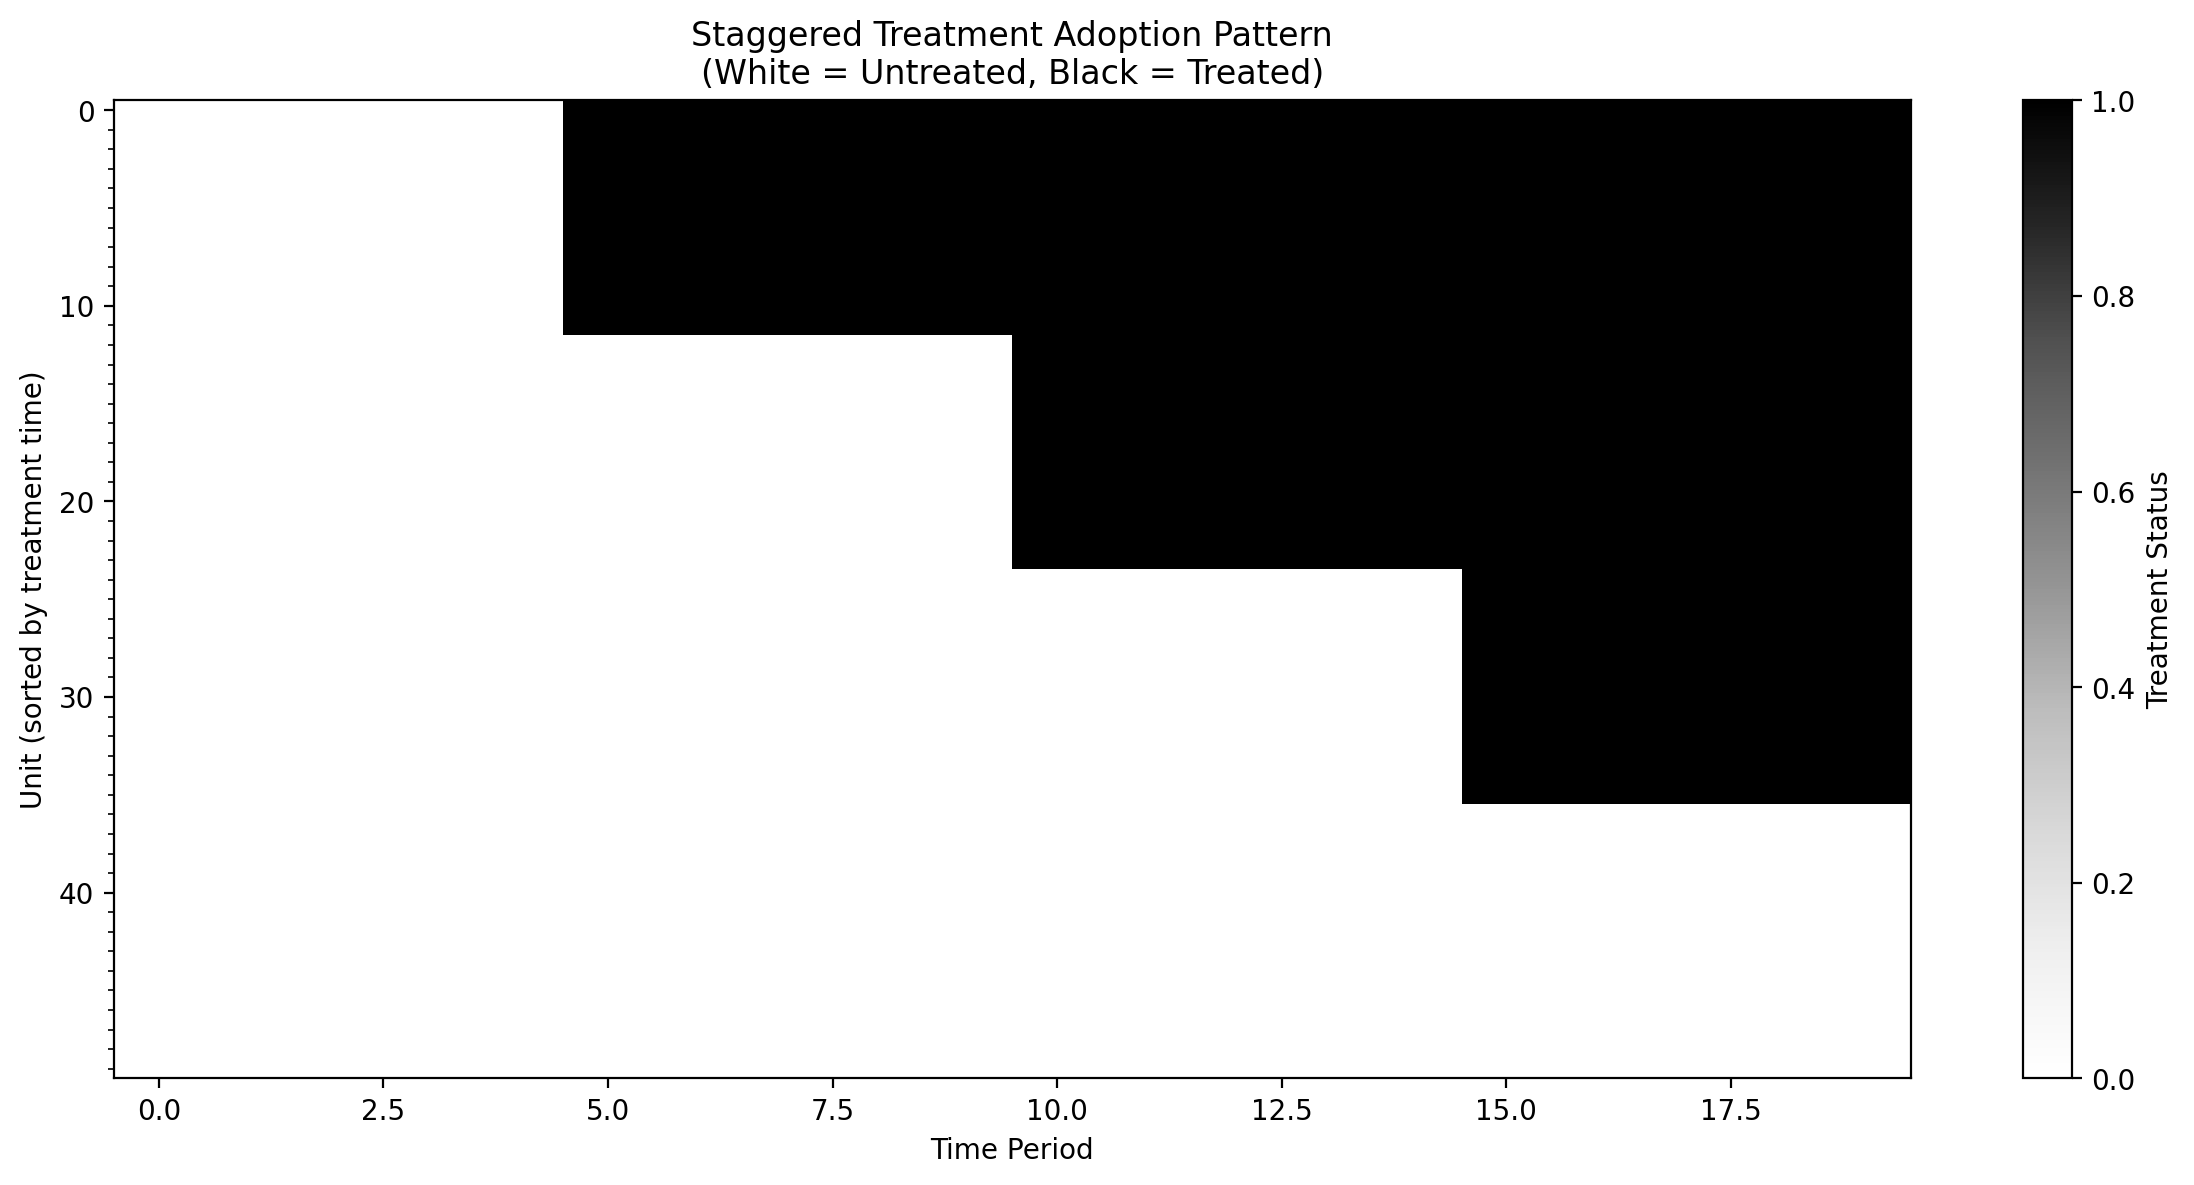

In [5]:
# Create a heatmap of treatment status
fig, ax = plt.subplots(figsize=(12, 6))

# Pivot to get unit x time matrix of treatment status
treatment_matrix = df.pivot(index="unit", columns="time", values="treated")

# Sort by treatment time for better visualization
unit_treatment_times = df.groupby("unit")["treatment_time"].first().sort_values()
treatment_matrix = treatment_matrix.loc[unit_treatment_times.index]

im = ax.imshow(
    treatment_matrix.values,
    aspect="auto",
    cmap="Greys",
    interpolation="nearest",
    vmin=0,
    vmax=1,
)
ax.set_xlabel("Time Period")
ax.set_ylabel("Unit (sorted by treatment time)")
ax.set_title(
    "Staggered Treatment Adoption Pattern\n(White = Untreated, Black = Treated)"
)
from matplotlib.ticker import MultipleLocator

ax.yaxis.set_minor_locator(MultipleLocator(1))
plt.colorbar(im, ax=ax, label="Treatment Status")
plt.tight_layout()
plt.show()

## Fit the Staggered DiD Model

We'll use a model with unit and time fixed effects, which is the baseline counterfactual model for imputation.

The formula defines a model of **untreated potential outcomes**. Crucially, this model is fitted only on observations that are not yet treated: pre-treatment periods for units that eventually receive treatment, plus all periods for never-treated units. The fitted model is then used to predict what the treated units *would have* experienced in the absence of treatment (the counterfactual). Treatment effects are computed as the difference between observed outcomes and these counterfactual predictions.

The formula `y ~ 1 + C(unit) + C(time)` specifies a two-way fixed effects model, but you're not limited to this specification. If you have additional covariates that help explain variation in the outcome—such as weather conditions, seasonality indicators, economic indicators, or any other time-varying controls—you can include them in the formula. For example, `y ~ 1 + C(unit) + C(time) + temperature + holiday` would add temperature and holiday effects to the model. Including relevant covariates can improve the precision of your treatment effect estimates and strengthen the plausibility of the parallel trends assumption.


In [6]:
# Fit the staggered DiD model with PyMC
result = cp.StaggeredDifferenceInDifferences(
    df,
    formula="y ~ 1 + C(unit) + C(time)",
    unit_variable_name="unit",
    time_variable_name="time",
    treated_variable_name="treated",
    treatment_time_variable_name="treatment_time",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "progressbar": True,
            "random_seed": 42,
        }
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]


## Event-Study Plot

The event-study plot shows the estimated treatment effect at each event-time (time relative to treatment). Key features:

- **Pre-treatment effects** (event-time < 0): These should be close to zero if the parallel trends assumption holds
- **Post-treatment effects** (event-time ≥ 0): These show the dynamic treatment effect over time since treatment
- **Error bars**: 94% Highest Density Intervals (HDI) from the Bayesian posterior

:::{note}
Since we generated synthetic data with known treatment effects, we can overlay the true effects on the plot to validate the estimator's performance. In real applications, the true effects are unknown.
:::

/var/folders/r0/nf1kgxsx6zx3rw16xc3wnnzr0000gn/T/ipykernel_42110/3138396324.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


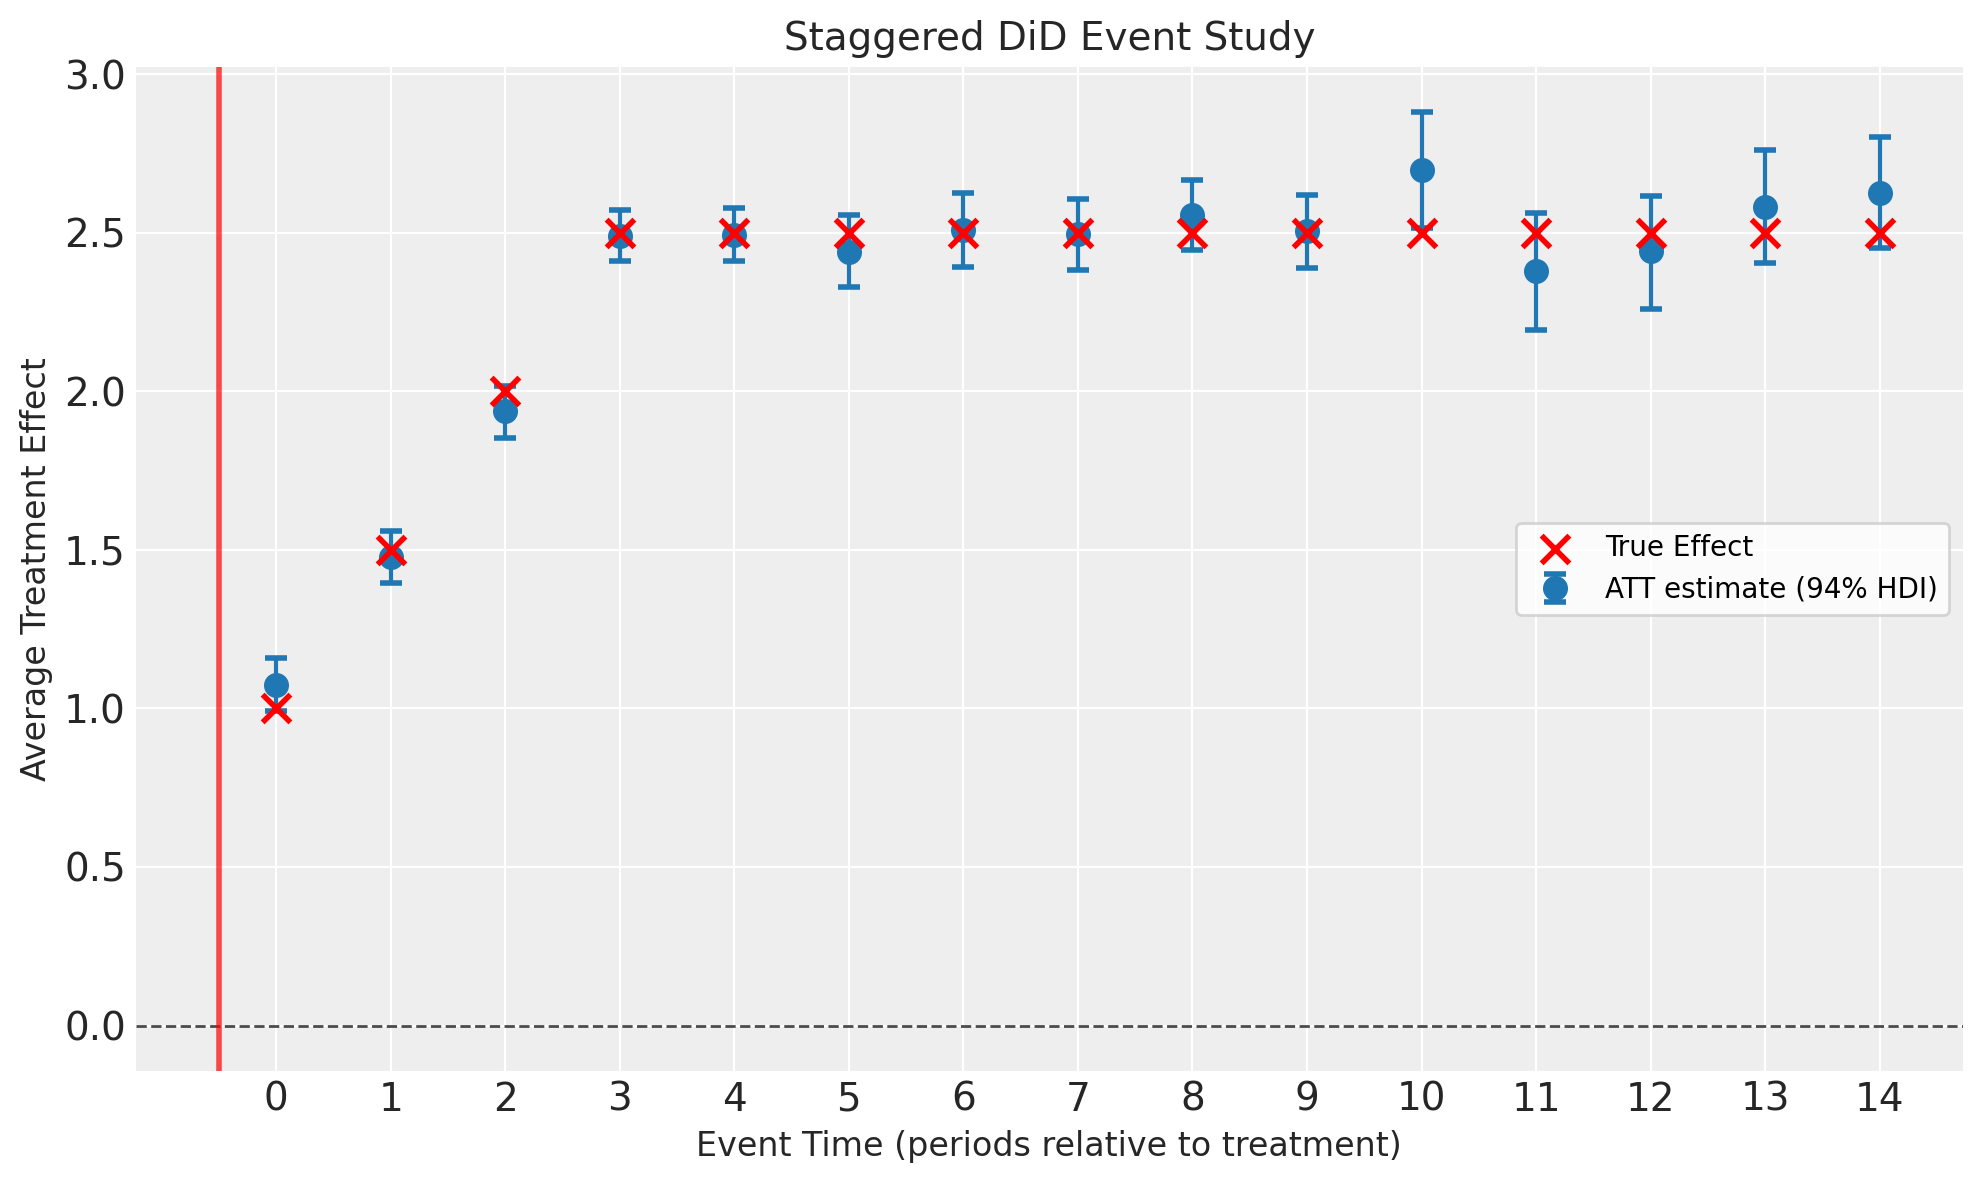

In [ ]:
fig, ax = result.plot()

# Overlay true treatment effects (only possible because we simulated the data)
att_et = result.att_event_time_
post_treatment = att_et[att_et["event_time"] >= 0]
true_vals = [TRUE_EFFECTS.get(e, 2.5) for e in post_treatment["event_time"]]
ax[0].scatter(
    post_treatment["event_time"],
    true_vals,
    color="red",
    marker="x",
    s=100,
    linewidths=2,
    zorder=5,
    label="True Effect",
)
ax[0].legend()

plt.show()

## View Summary Statistics


In [8]:
result.summary(round_to=2)

======================Staggered Difference in Differences=======================
Formula: y ~ 1 + C(unit) + C(time)
Number of units: 50
Number of time periods: 20
Treatment cohorts: [np.float64(5.0), np.float64(10.0), np.float64(15.0)]
Never-treated units: 14

Event-time ATT estimates:
 event_time      att  att_lower  att_upper  n_obs
          0 1.074842   0.990362   1.159714     36
          1 1.477406   1.395102   1.559364     36
          2 1.936514   1.854290   2.016924     36
          3 2.491325   2.412439   2.572188     36
          4 2.494277   2.412555   2.577045     36
          5 2.439444   2.327826   2.554720     24
          6 2.508034   2.391311   2.625448     24
          7 2.495111   2.382095   2.607191     24
          8 2.554547   2.444958   2.666289     24
          9 2.504438   2.390342   2.620304     24
         10 2.699058   2.515626   2.879858     12
         11 2.379267   2.192838   2.562129     12
         12 2.441211   2.260847   2.617471     12
         13 2

## Effect Summary

Get a prose summary of the causal effects:


In [9]:
effect_summary = result.effect_summary()
print(effect_summary.text)

Staggered DiD analysis: The average post-treatment effect across event-times was 2.31 (average 95% HDI [2.19, 2.44]). Analysis includes 3 treatment cohort(s).


## Examine the Event-Time ATT Table


In [10]:
result.att_event_time_

,event_time,att,att_lower,att_upper,n_obs
0,0,1.074842,0.990362,1.159714,36
1,1,1.477406,1.395102,1.559364,36
2,2,1.936514,1.854290,2.016924,36
3,3,2.491325,2.412439,2.572188,36
4,4,2.494277,2.412555,2.577045,36
5,5,2.439444,2.327826,2.554720,24
6,6,2.508034,2.391311,2.625448,24
7,7,2.495111,2.382095,2.607191,24
8,8,2.554547,2.444958,2.666289,24
9,9,2.504438,2.390342,2.620304,24


## Group-Time ATT Table

The group-time ATT table shows effects for each combination of treatment cohort (G) and calendar time (t):


In [11]:
result.att_group_time_.head(20)

,cohort,time,att,att_lower,att_upper
0,5.0,5,1.105831,0.981070,1.234096
1,5.0,6,1.313366,1.191865,1.438411
2,5.0,7,1.874254,1.738034,2.002803
3,5.0,8,2.324531,2.195446,2.449806
4,5.0,9,2.495319,2.365605,2.621871
5,5.0,10,2.330355,2.188604,2.468263
6,5.0,11,2.469498,2.326770,2.611914
7,5.0,12,2.452538,2.311010,2.599357
8,5.0,13,2.521460,2.381104,2.661465
9,5.0,14,2.492747,2.348853,2.636524


## Using scikit-learn Models

For faster analysis, you can use scikit-learn models. The error bars in the plot represent approximate 95% confidence intervals, computed as ±1.96 standard errors where the standard error is derived from the standard deviation of the individual treatment effects within each event-time bin divided by the square root of the number of observations.


In [12]:
from sklearn.linear_model import LinearRegression

result_ols = cp.StaggeredDifferenceInDifferences(
    df,
    formula="y ~ 1 + C(unit) + C(time)",
    unit_variable_name="unit",
    time_variable_name="time",
    treated_variable_name="treated",
    treatment_time_variable_name="treatment_time",
    model=LinearRegression(),
)

/var/folders/r0/nf1kgxsx6zx3rw16xc3wnnzr0000gn/T/ipykernel_42110/1075362460.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


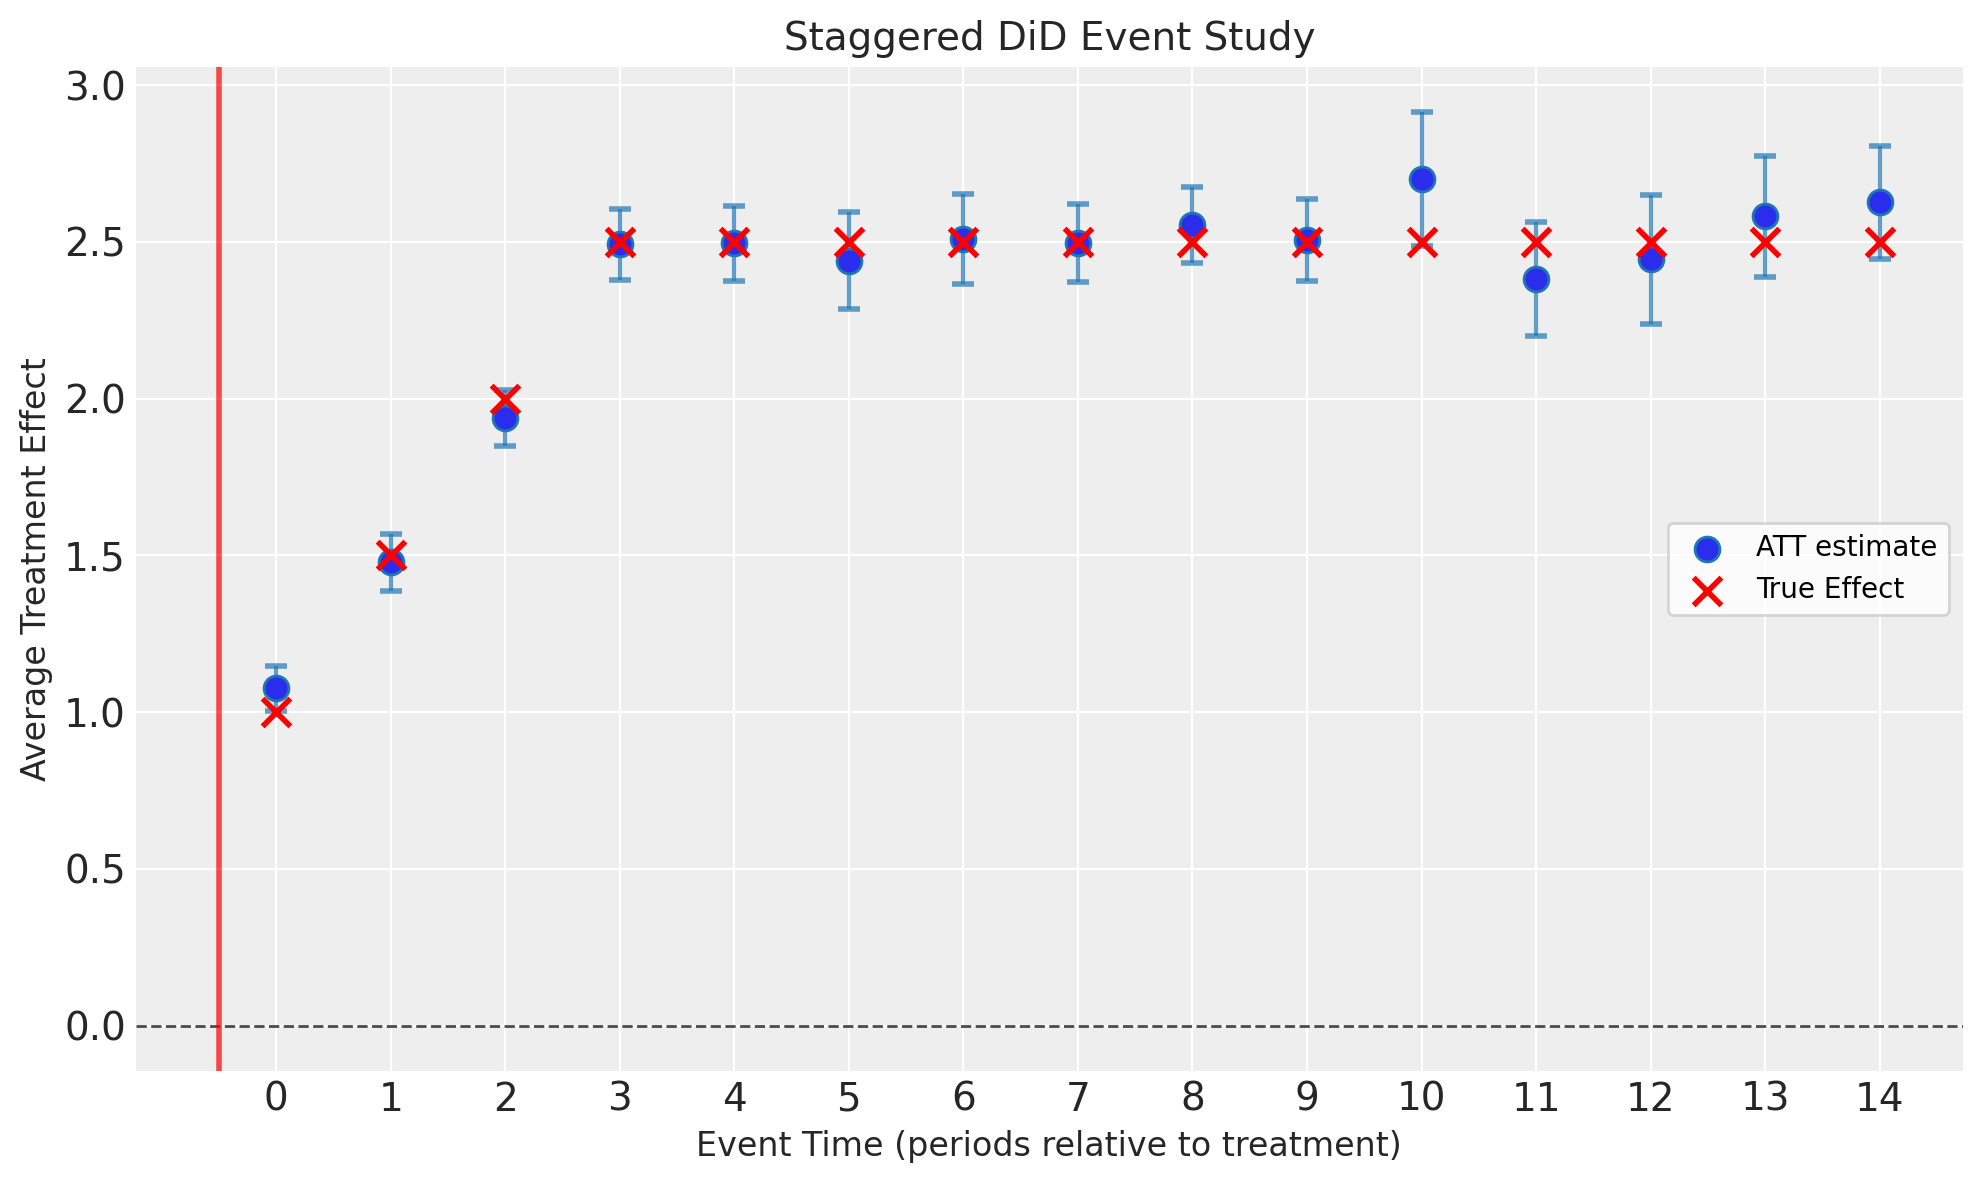

In [ ]:
fig, ax = result_ols.plot()

# Overlay true treatment effects (only possible because we simulated the data)
att_et_ols = result_ols.att_event_time_
post_treatment_ols = att_et_ols[att_et_ols["event_time"] >= 0]
true_vals_ols = [TRUE_EFFECTS.get(e, 2.5) for e in post_treatment_ols["event_time"]]
ax[0].scatter(
    post_treatment_ols["event_time"],
    true_vals_ols,
    color="red",
    marker="x",
    s=100,
    linewidths=2,
    zorder=5,
    label="True Effect",
)
ax[0].legend()

plt.show()

## Key Takeaways

1. **Staggered adoption requires special handling** - standard TWFE can produce biased estimates

2. **The imputation approach** fits a model on untreated observations and predicts counterfactuals

3. **Event-study curves** show dynamic treatment effects and allow for parallel trends checks

4. **Pre-treatment effects** near zero support the parallel trends assumption

5. **CausalPy supports both Bayesian and OLS** approaches for flexibility


## References

:::{bibliography}
:filter: docname in docnames
:::
